<a href="https://colab.research.google.com/github/jibbals/supersat/blob/master/Superres_v2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Super resolution

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


In [0]:
  !curl -s https://course.fast.ai/setup/colab | bash


Updating fastai...
Done.


In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

In [0]:
#path = untar_data(URLs.PETS)
#path_hr = path/'images'
#path_lr = path/'small-96'
#path_mr = path/'small-256'


path = base_dir + '3800 images/batch2_3800'

path_hr = Path(path + '/SH')
path_mr = Path(path + '/SM')
path_lr = Path(path + '/SL')
path_land_sat = Path(path +'/Land_Sat')

print(os.path.isdir(path_lr))
print(path_lr)
print(str(path_lr))
import glob
print(glob.glob(str(path_lr)+'/*'))
print(glob.glob('/content/gdrive/My Drive/fastai-v3/All Images/SL/*'))

True
/content/gdrive/My Drive/fastai-v3/3800 images/batch2_3800/SL
/content/gdrive/My Drive/fastai-v3/3800 images/batch2_3800/SL
['/content/gdrive/My Drive/fastai-v3/3800 images/batch2_3800/SL/5679_04.png', '/content/gdrive/My Drive/fastai-v3/3800 images/batch2_3800/SL/7232_01.png', '/content/gdrive/My Drive/fastai-v3/3800 images/batch2_3800/SL/8525_00.png', '/content/gdrive/My Drive/fastai-v3/3800 images/batch2_3800/SL/3548_04.png', '/content/gdrive/My Drive/fastai-v3/3800 images/batch2_3800/SL/8536_01.png', '/content/gdrive/My Drive/fastai-v3/3800 images/batch2_3800/SL/9810_00.png', '/content/gdrive/My Drive/fastai-v3/3800 images/batch2_3800/SL/2659_05.png', '/content/gdrive/My Drive/fastai-v3/3800 images/batch2_3800/SL/4898_01.png', '/content/gdrive/My Drive/fastai-v3/3800 images/batch2_3800/SL/3273_01.png', '/content/gdrive/My Drive/fastai-v3/3800 images/batch2_3800/SL/5146_00.png', '/content/gdrive/My Drive/fastai-v3/3800 images/batch2_3800/SL/8459_00.png', '/content/gdrive/My Dri

In [0]:
free = gpu_mem_get_free_no_cache()
free


16270

In [0]:
il = ImageList.from_folder(path_hr)

In [0]:
# def resize_one(fn, i, path, size):
#     dest = path/fn.relative_to(path_hr)
#     dest.parent.mkdir(parents=True, exist_ok=True)
#     img = PIL.Image.open(fn)
#     targ_sz = resize_to(img, size, use_min=True)
#     img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
#     img.save(dest, quality=60)

In [0]:
# create smaller image sets the first time this nb is run
# sets = [(path_lr, 96), (path_mr, 256)]
# for p,size in sets:
#     if not p.exists(): 
#         print(f"resizing to {size} into {p}")
#         parallel(partial(resize_one, path=p, size=size), il.items)

In [0]:
bs,size=10,400 #32,128.  6,400 works
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [0]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
data = get_data(bs,size)
data

ImageDataBunch;

Train: LabelList (2106 items)
x: ImageImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
Path: /content/gdrive/My Drive/fastai-v3/3800 images/batch2_3800/SL;

Valid: LabelList (234 items)
x: ImageImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
Path: /content/gdrive/My Drive/fastai-v3/3800 images/batch2_3800/SL;

Test: None

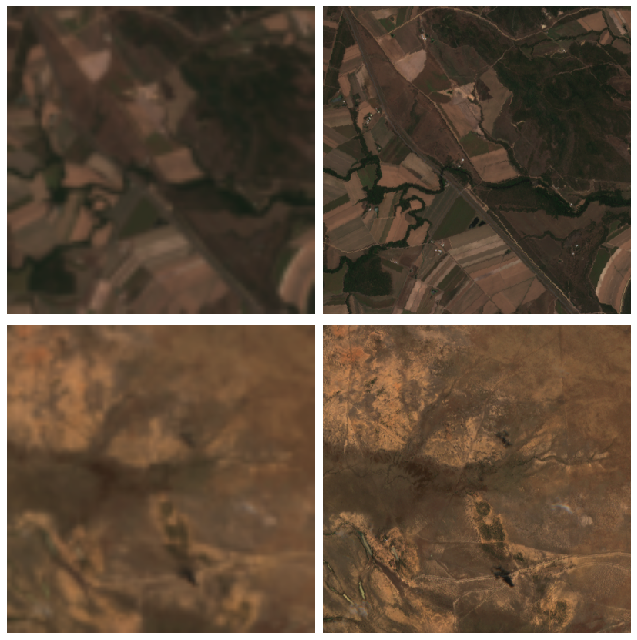

In [0]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Feature loss

In [0]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [0]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [0]:
gram_matrix(t)

tensor([[[0.0254, 0.0203, 0.0157],
         [0.0203, 0.0164, 0.0126],
         [0.0157, 0.0126, 0.0098]],

        [[0.0254, 0.0203, 0.0157],
         [0.0203, 0.0164, 0.0126],
         [0.0157, 0.0126, 0.0098]]])

In [0]:
base_loss = F.l1_loss

In [0]:
# copy_to = '/root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth'
# copy_from = base_dir + 'vgg16_bn-6c64b313.pth'
# print(copy_from)
# shutil.copyfile(copy_from, copy_to) 

In [0]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [0]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [0]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [0]:
# copy_to = '/root/.cache/torch/checkpoints/resnet34-333f7ec4.pth'
# copy_from = base_dir + 'resnet34-333f7ec4.pth'
# print(copy_from)
# shutil.copyfile(copy_from, copy_to) 

## Train

In [0]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight).to_fp16()
gc.collect();

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


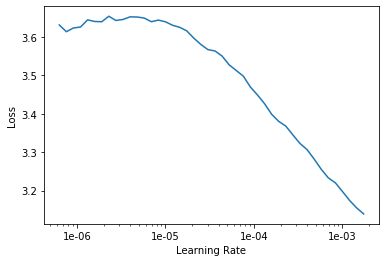

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 5e-4

In [0]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(15, lrs, pct_start=pct_start,callbacks=[ShowGraph(learn), SaveModelCallback(learn,monitor='valid_loss', mode='min',name=save_name)]) #was 10
    #learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)





epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.250176,1.199965,0.089467,0.239259,0.210829,0.031155,0.365552,0.250027,0.013675,14:37
1,1.041359,1.101911,0.079001,0.229430,0.201734,0.029309,0.325177,0.224785,0.012475,03:42
2,0.998989,1.042322,0.077559,0.225733,0.196686,0.028620,0.293752,0.207863,0.012107,03:42
3,0.974427,1.052978,0.086310,0.225119,0.196190,0.028681,0.296951,0.207712,0.012015,03:42
4,0.964662,1.103807,0.102370,0.222911,0.195716,0.029366,0.322001,0.219186,0.012257,03:42
5,0.967941,1.032233,0.074991,0.223489,0.193527,0.028587,0.293175,0.206470,0.011995,03:42
6,0.942201,1.040707,0.083451,0.217076,0.191717,0.028951,0.304686,0.203053,0.011772,03:42
7,0.946985,1.030063,0.087566,0.226031,0.196042,0.029059,0.277792,0.201733,0.011841,03:42
8,0.938767,1.005368,0.072673,0.219461,0.192296,0.028265,0.278986,0.201954,0.011732,03:42
9,0.931154,1.073938,0.093398,0.218905,0.194469,0.029477,0.314086,0.211636,0.011967,03:42


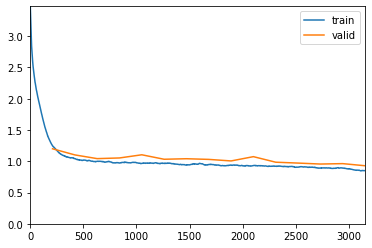

Better model found at epoch 0 with valid_loss value: 1.1999651193618774.
Better model found at epoch 1 with valid_loss value: 1.1019105911254883.
Better model found at epoch 2 with valid_loss value: 1.0423219203948975.
Better model found at epoch 5 with valid_loss value: 1.0322332382202148.
Better model found at epoch 7 with valid_loss value: 1.0300631523132324.
Better model found at epoch 8 with valid_loss value: 1.0053682327270508.
Better model found at epoch 10 with valid_loss value: 0.985061526298523.
Better model found at epoch 11 with valid_loss value: 0.9711215496063232.
Better model found at epoch 12 with valid_loss value: 0.9557050466537476.
Better model found at epoch 14 with valid_loss value: 0.928582489490509.


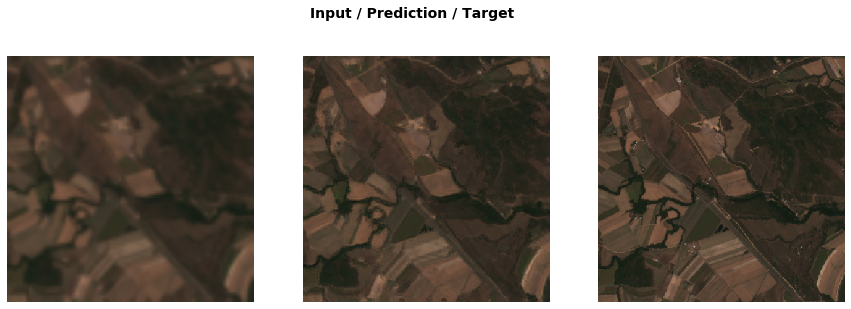

In [0]:
do_fit('1av2.2', slice(lr*10))

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,0.844402,0.926336,0.067843,0.216272,0.189365,0.028640,0.235301,0.177567,0.011347,03:50
1,0.843798,0.927131,0.068210,0.216325,0.189362,0.028546,0.235902,0.177437,0.011348,03:50
2,0.844566,0.926694,0.067896,0.215174,0.188542,0.028432,0.237440,0.177865,0.011345,03:50
3,0.848095,0.923087,0.067726,0.216579,0.189731,0.028800,0.232418,0.176482,0.011351,03:50
4,0.841752,0.918124,0.068248,0.216493,0.189649,0.028703,0.229015,0.174691,0.011325,03:50
5,0.843639,0.915043,0.067889,0.216256,0.188680,0.028746,0.228281,0.173909,0.011281,03:50
6,0.837908,0.923976,0.067836,0.216027,0.189167,0.028522,0.234482,0.176625,0.011318,03:50
7,0.839770,0.930838,0.068714,0.216461,0.189353,0.028497,0.237675,0.178830,0.011307,03:50
8,0.844087,0.928393,0.068721,0.215330,0.189089,0.028249,0.237430,0.178229,0.011345,03:50


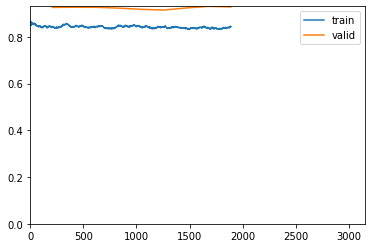

Better model found at epoch 0 with valid_loss value: 0.9263361692428589.
Better model found at epoch 3 with valid_loss value: 0.9230873584747314.
Better model found at epoch 4 with valid_loss value: 0.918124258518219.
Better model found at epoch 5 with valid_loss value: 0.9150429964065552.


KeyboardInterrupt: ignored

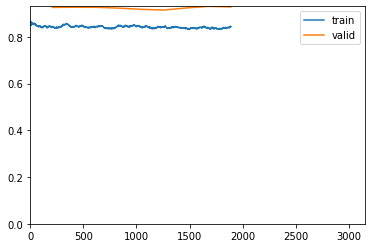

In [0]:
do_fit('1bv2.2', slice(1e-5,lr,)) #could do with more loops maybe 20 but would take 30mins

In [0]:
# data = get_data(12,size*2)

In [0]:
# learn.data = data
# learn.freeze()
# gc.collect()

4658

In [0]:
learn.load('1bv2.2');

In [0]:
# do_fit('2av2')

In [0]:
#  learn.unfreeze()

In [0]:
# do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

In [0]:
#learn.save('2b');

## Test

In [0]:
learn = None
gc.collect();

In [0]:
#256/320*1024

In [0]:
#256/320*1600

In [0]:
free = gpu_mem_get_free_no_cache()
# the max size of the test image depends on the available GPU RAM 
if free > 8000: size=(400, 400) # >  8GB RAM
else:           size=( 400, 400) # <= 8GB RAM
print(f"using size={size}, have {free}MB of GPU RAM free")

using size=(400, 400), have 9601MB of GPU RAM free


In [0]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)


In [0]:
data_mr = (ImageImageList.from_folder(path_land_sat).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_land_sat/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3
#path_mr
#path_hr
data_mr

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:454: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")
/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:457: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


ImageDataBunch;

Train: LabelList (0 items)
x: ImageImageList

y: ImageList

Path: /content/gdrive/My Drive/fastai-v3/3800 images/batch2_3800/Land_Sat;

Valid: LabelList (0 items)
x: ImageImageList

y: ImageList

Path: /content/gdrive/My Drive/fastai-v3/3800 images/batch2_3800/Land_Sat;

Test: None

In [0]:
learn.load('1bv2.2'); #should be 2b


In [0]:
learn.data = data_mr

In [0]:
fn = data_mr.valid_ds.x.items[1]; fn


IndexError: ignored

In [0]:
img = open_image(fn); img.shape

NameError: ignored

In [0]:
p,img_hr,b = learn.predict(img)

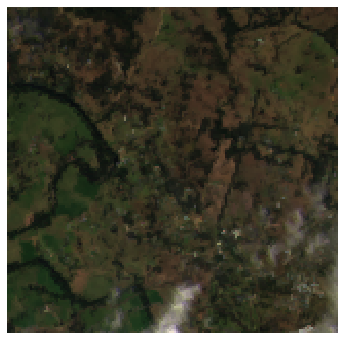

In [0]:
show_image(img, figsize=(6,6), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


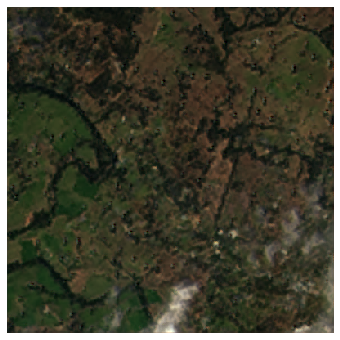

In [0]:
Image(img_hr).show(figsize=(6,6))

In [0]:
import zipfile
path2 = base_dir + '3800 images/batch2_3800.zip'
path3 = base_dir + '3800 images'

print(os.path.isfile(path2))

with zipfile.ZipFile(path2, 'r') as zip_ref:
    zip_ref.extractall(path3)

True
